In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

In [2]:
rfmDate = dt.datetime(2017, 12, 31)
# Load Data
data = 'Dataset-RFM.xlsx'
Orders = pd.read_excel(data, sheet_name= 'Orders', index_col = 'Row ID').reset_index(drop=True)
Product = pd.read_excel(data, sheet_name= 'Product', index_col = 'Row ID')
Location = pd.read_excel(data, sheet_name= 'Location', index_col = 'Row ID')
Customer = pd.read_excel(data, sheet_name= 'Customer', index_col = 'Row ID')
Return = pd.read_excel(data, sheet_name= 'Return')
#
Orders['Year'] = pd.DatetimeIndex(Orders['Order Date']).year
Orders['Order Date'] = pd.to_datetime(Orders['Order Date'])

In [3]:
#Join
OC = Orders.merge(Customer, on = 'Customer ID', suffixes = ["_Order", "_Customer"])
OCR = OC.merge(Return, how = 'outer', on = 'Order ID', suffixes = ["_O-C", "_Return"])
#remove Returned Order
OCR = OCR.query('Returned.isnull()').drop('Returned', axis = 1)

In [4]:
#Recency
recency = (rfmDate - OCR.groupby('Customer ID').agg({'Order Date':max})).reset_index()
recency['Order Date'] = recency['Order Date'].dt.days
recency = recency.rename(columns = {'Order Date': 'recent'})
rQ1 = recency['recent'].quantile(0.25)
rQ2 = recency['recent'].quantile(0.5)
rQ3 = recency['recent'].quantile(0.75)
rIQR = rQ3 - rQ1
rConditions = [(recency['recent'] <= rQ1),
               (recency['recent'] > rQ1) & (recency['recent'] <= rQ2),
               (recency['recent'] > rQ2) & (recency['recent'] <= rQ3),
               (recency['recent'] > rQ3) & (recency['recent'] <= rQ3+1.5*rIQR),
               (recency['recent'] > rQ3+1.5*rIQR)]
rValues = [5, 4, 3, 2, 1]
recency['rPoint'] = np.select(rConditions, rValues)
recency = recency.sort_values('Customer ID').reset_index(drop = True)

In [5]:
#Frequency
frequency = OCR.groupby(['Order ID', 'Customer ID']).agg({'Sales': sum}).reset_index().sort_values('Customer ID')
frequency = frequency.sort_values(['Customer ID', 'Sales'], ascending = [True, False]).reset_index(drop = True)
frequency = pd.DataFrame(frequency[['Customer ID']].value_counts()).reset_index().rename(columns = {0: 'frequency'})
fQ1 = frequency['frequency'].quantile(0.25)
fQ2 = frequency['frequency'].quantile(0.5)
fQ3 = frequency['frequency'].quantile(0.75)
fIQR = fQ3 - fQ1
fConditions = [(frequency['frequency'] <= fQ1),
               (frequency['frequency'] > fQ1) & (frequency['frequency'] <= fQ2),
               (frequency['frequency'] > fQ2) & (frequency['frequency'] <= fQ3),
               (frequency['frequency'] > fQ3) & (frequency['frequency'] <= fQ3 + 1.5*fIQR),
               (frequency['frequency'] > fQ3 + 1.5*fIQR)]
fValues = [1, 2, 3, 4, 5]
frequency['fPoint'] = np.select(fConditions, fValues)
frequency = frequency.sort_values('Customer ID').reset_index(drop = True)

In [6]:
#Monetary
monetary = OCR.groupby('Customer ID').agg({'Sales': sum}).reset_index()
mQ1 = monetary['Sales'].quantile(0.25)
mQ2 = monetary['Sales'].quantile(0.5)
mQ3 = monetary['Sales'].quantile(0.75)
mIQR = mQ3 - mQ1
mConditions = [(monetary['Sales'] <= mQ1),
               (monetary['Sales'] > mQ1) & (monetary['Sales'] <= mQ2),
               (monetary['Sales'] > mQ2) & (monetary['Sales'] <= mQ3),
               (monetary['Sales'] > mQ3) & (monetary['Sales'] <= mQ3 + 1.5*mIQR),
               (monetary['Sales'] > mQ3 + 1.5*mIQR)]
mValues = [1, 2, 3, 4, 5]
monetary['mPoint'] = np.select(mConditions, mValues)
monetary = monetary.sort_values('Customer ID').reset_index(drop = True)

In [7]:
#Customer Segmentation
# RFM Df
RFM = Customer.merge(recency, on = 'Customer ID')\
        .merge(frequency, on = 'Customer ID')\
        .merge(monetary, on = 'Customer ID')
RFM['rfm'] = RFM['rPoint'].astype(str) \
    + RFM['fPoint'].astype(str) \
    + RFM['mPoint'].astype(str)
RFM = RFM.iloc[:,[0,-1]].sort_values('Customer ID').reset_index(drop = True)
RFM['segment'] = RFM['rfm'].astype(int)

#List customer segmentation
Champions = [555, 554, 544, 545, 454, 455, 445]
Loyal = [543, 444, 435, 355, 354, 345, 344, 335]
Potential_Loyalist = [553, 551, 552, 541, 542, 533, 532, 531, 452, 451, 442, 441,
                      431, 453, 433, 432, 423, 353, 352, 351, 342, 341, 333, 323]
New_Customers = [512, 511, 422, 421, 412, 411, 311]
Promising = [525, 524, 523, 522, 521, 515, 514, 513, 425,424, 413,414,415, 315, 314, 313]
Need_Attention = [535, 534, 443, 434, 343, 334, 325, 324]
About_To_Sleep = [331, 321, 312, 221, 213, 231, 241, 251]
At_Risk = [255, 254, 245, 244, 253, 252, 243, 242, 235, 234, 225, 224, 153, 
           152, 145, 143, 142, 135, 134, 133, 125, 124]
Cannot_Lose_Them = [155, 154, 144, 214,215,115, 114, 113]
Hibernating_customers = [332, 322, 233, 232, 223, 222, 132, 123, 122, 212, 211]
Lost_customers = [111, 112, 121, 131,141,151]

#SegmentDf
segmentDf = RFM
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(Champions),'Champions')
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(Loyal),'Loyal')
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(Potential_Loyalist),'Potential Loyalist')
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(New_Customers),'New Customers')
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(Promising),'Promising')
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(Need_Attention),'Need Attention')
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(About_To_Sleep),'About To Sleep')
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(At_Risk),'At Risk')
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(Cannot_Lose_Them),'Cannot Lose Them')
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(Hibernating_customers),'Hibernating customers')
segmentDf['segment'] = segmentDf['segment'].mask(segmentDf['segment'].isin(Lost_customers),'Lost customers')
segmentDf =segmentDf.iloc[:,[0,-1]]

In [8]:
OCRS = OCR.merge(segmentDf, on = "Customer ID")

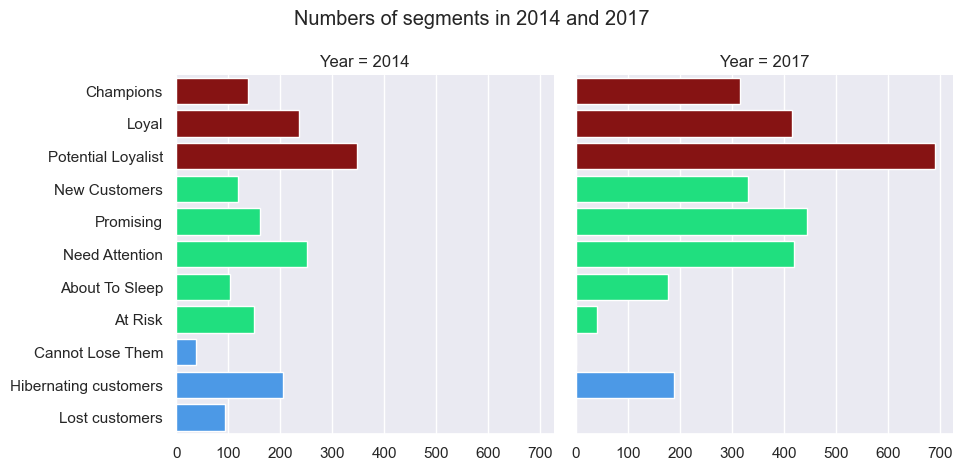

In [9]:
sns.set()
color_segment = ['#990000', '#990000', '#990000',
                '#00FF7F', '#00FF7F', '#00FF7F', '#00FF7F', '#00FF7F', 
                '#3399FF', '#3399FF', '#3399FF']
#sns.color_palette([color_segment])
order_segment = ['Champions', 'Loyal', 'Potential Loyalist', 
                 'New Customers','Promising', 'Need Attention', 'About To Sleep', 'At Risk',
                 'Cannot Lose Them', 'Hibernating customers','Lost customers']

g=sns.catplot(kind = 'count', data = OCRS.query('Year == 2014 | Year == 2017'),
             y = 'segment', col = 'Year', order = order_segment,
             palette=sns.color_palette(color_segment))
g.set(xlabel ="", ylabel = "")
g.fig.subplots_adjust(top=0.85)
g.fig.suptitle('Numbers of segments in 2014 and 2017')
plt.show()